In [273]:
import os
import _pickle as pickle
import chainconsumer as cc
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-notebook')
mpl.rcParams['figure.dpi'] = 240
path = os.path.expanduser("~/raid/lsst/")

In [151]:
#print(results.keys())
#print(results["fitmodels"].keys())
#print(len(results["galfits"]["galsim"]))
#print(results["galfits"]["galsim"][0].keys())
# galfits[0] - PSF image
# galfits[1:len] - PSF models

dict_keys(['fitmodels', 'galfits', 'psfmodel', 'psfname', 'psfmodelname', 'seed'])
dict_keys(['backgroundsbyband', 'models', 'modelspsf', 'galaxies', 'psfs'])
936
dict_keys(['params', 'paramsbest', 'modeltype', 'modeltypefit', 'psfname', 'psfmodelname', 'time'])


In [274]:
galfits = results["galfits"]["galsim"]
models = {"None": None}
models.update(results["fitmodels"]["models"])

rows = []
columnsbyname = {
    'PSF.model': 'psfname',
    'PSF.model.fit': 'psfmodelname',
    'Galaxy.model': 'modeltype',
    'Galaxy.model.fit': 'modeltypefit',
}

psfmodels = ["gaussian:1"]
psfmodelsfit = ["","gaussian:1"]
for psfmodel in psfmodels:
    for psfmodelfit in psfmodelsfit:
        filename = "_".join([path + "multiprofit2_", psfmodel, "0", psfmodelfit]) + ".dat"
        with open(os.path.expanduser(filename), 'rb') as f:
            results = pickle.load(f)
            galfits = results["galfits"]["galsim"]
            for galfit in galfits:
                row = { dest: galfit[src] for dest, src in columnsbyname.items()}
                paramsbest = galfit["paramsbest"]
                failed = paramsbest is None
                fluxmodel = np.nan if failed else paramsbest[2]
                diffx = np.nan if failed else paramsbest[0] - galfit["params"][0]
                diffy = np.nan if failed else paramsbest[1] - galfit["params"][1]
                timerun = 0 if galfit["time"] is None else galfit["time"]
                row.update({
                    'Flux.model': fluxmodel,
                    'Flux.true': galfit["params"][2],
                    'Xdiff': diffx,
                    'Ydiff': diffy,
                    'R50.pix': 0,
                    'R50.pix.model': 0,
                    'time': timerun,
                })
                rows.append(row)
table = pd.DataFrame(rows)
isimg = table["PSF.model.fit"] == ""
table["PSF.model.fit"][isimg] = "image"
print(table.shape)
print(np.sum(np.isnan(table["Flux.model"])))
galaxymodels = np.unique(table["Galaxy.model"])
for galaxymodel in galaxymodels:
    print(galaxymodel, np.sum(table["Galaxy.model"] == galaxymodel))
galaxymodelsfit = np.unique(table["Galaxy.model.fit"])

(1872, 11)
296
expser 1440
sersic:1 432


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


['expser' 'sersic:1']
expser 1440
714
480
sersic:1 432
166
216


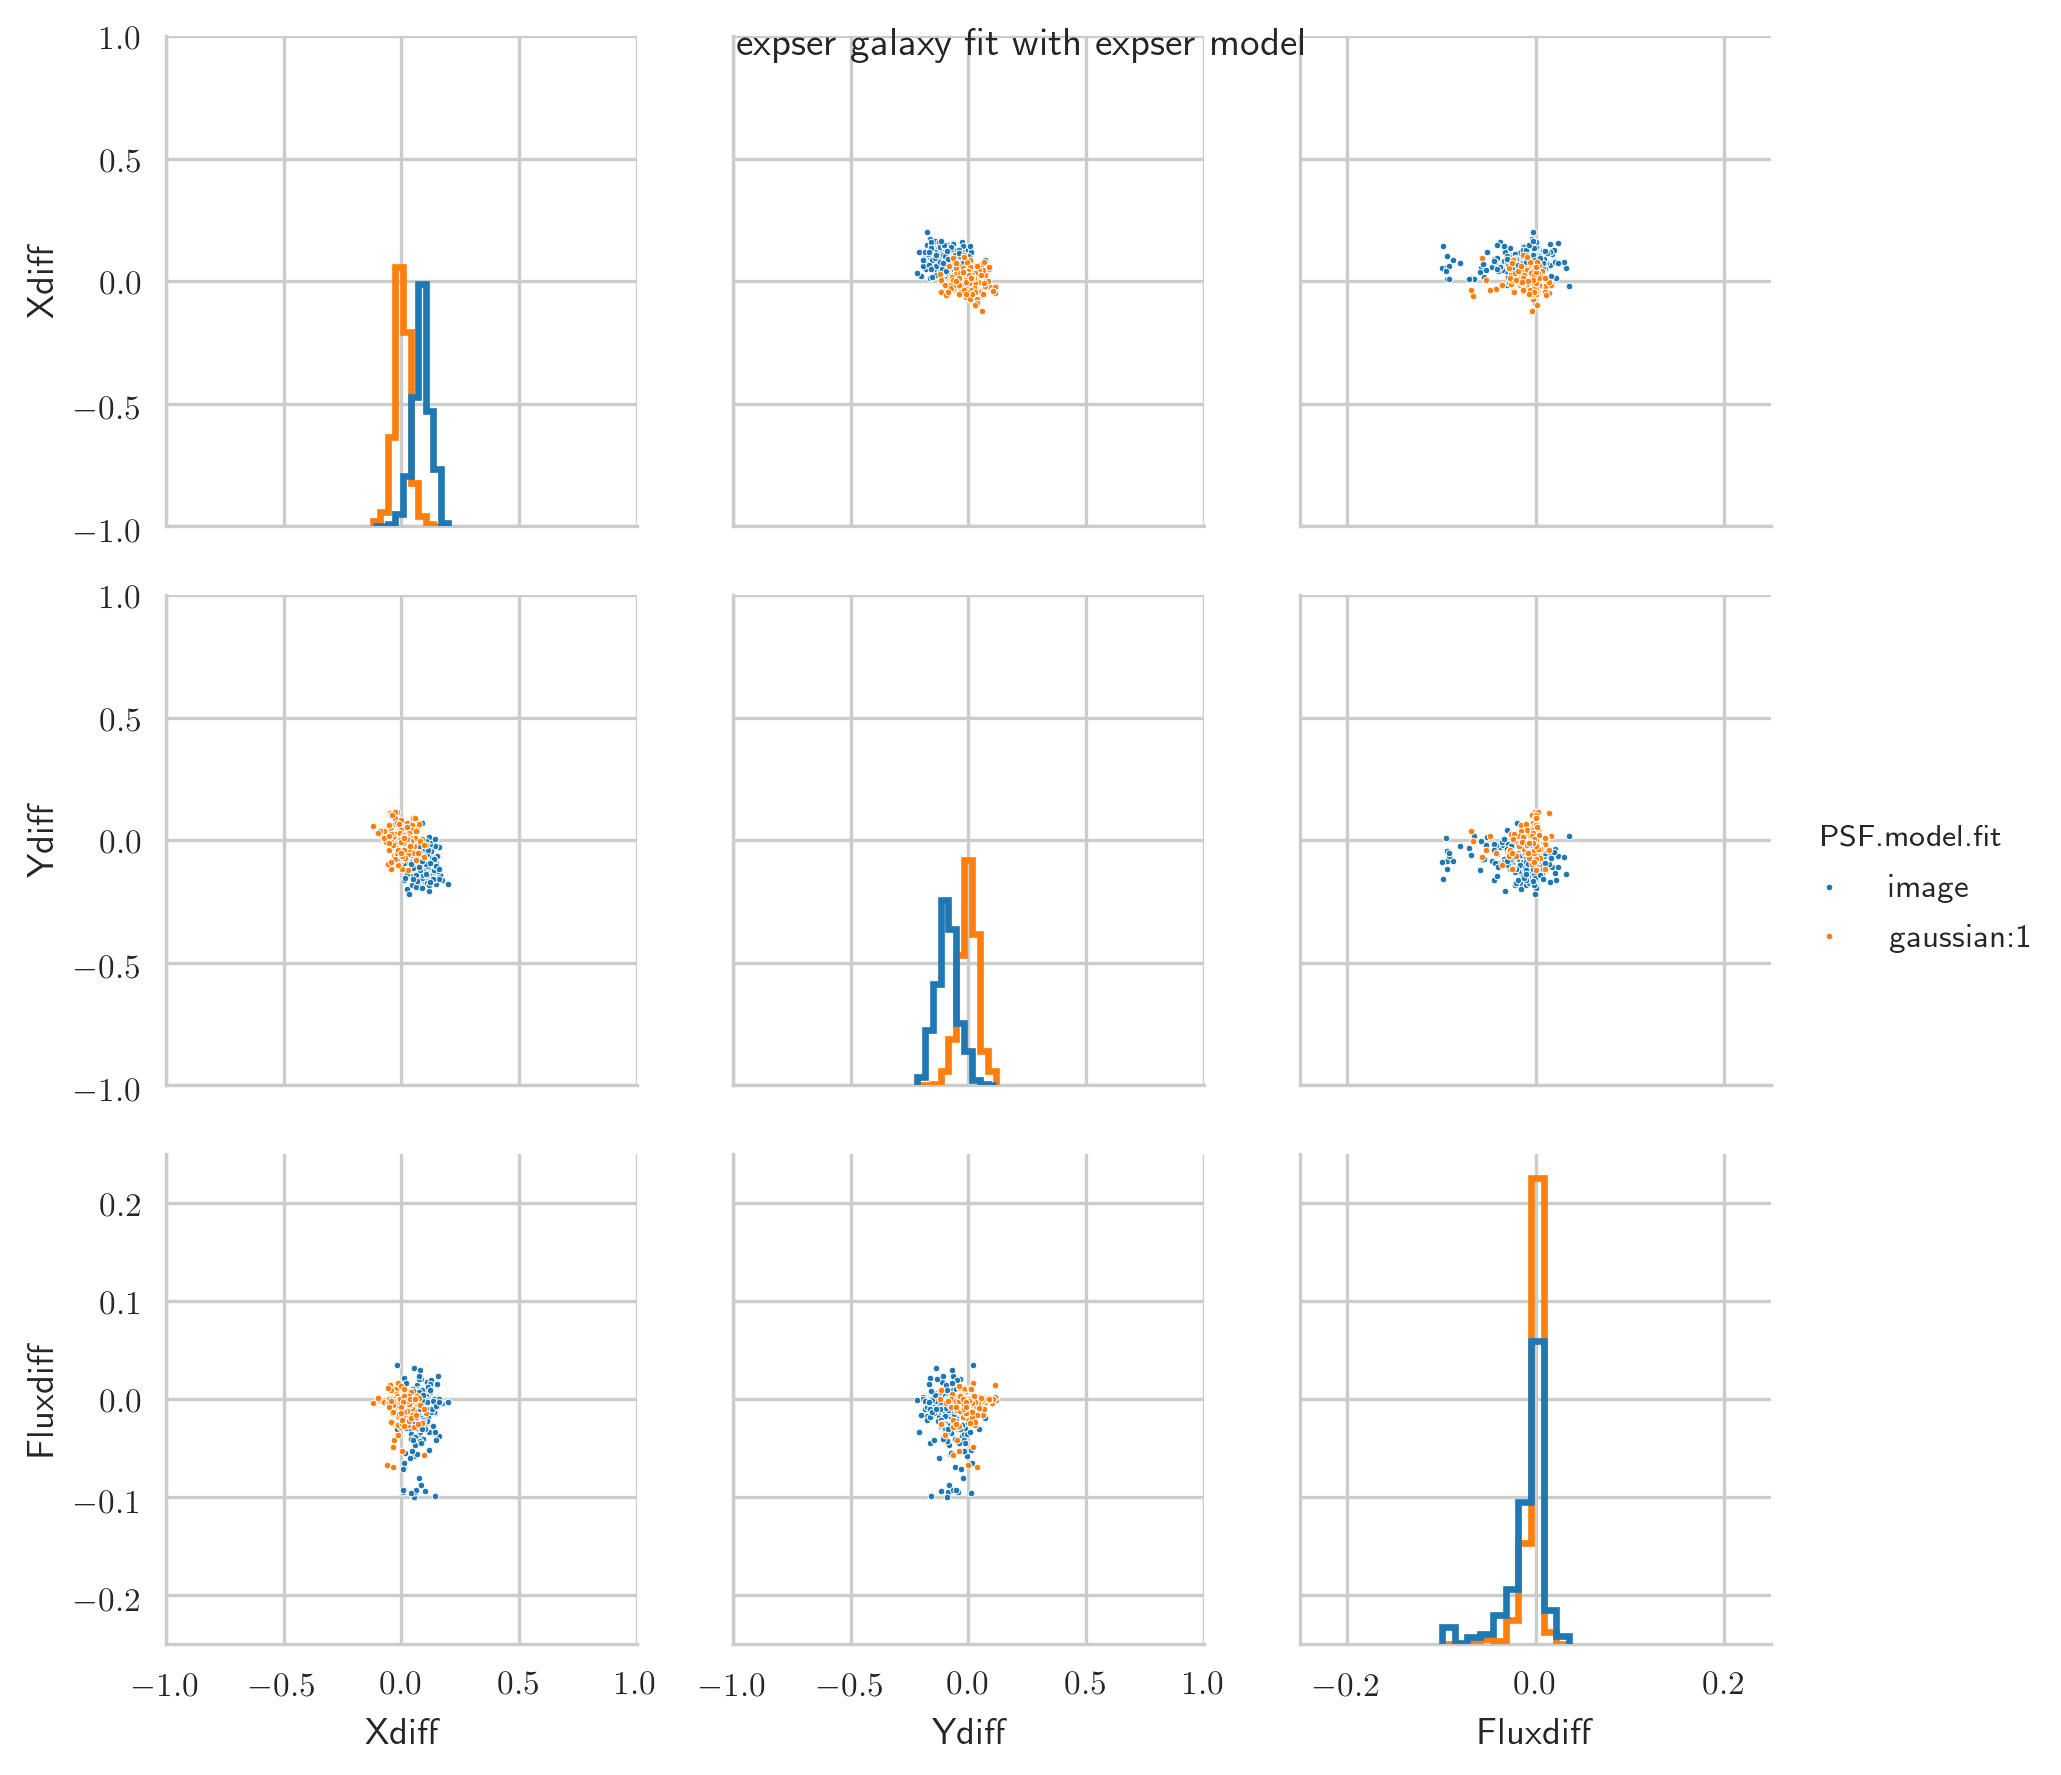

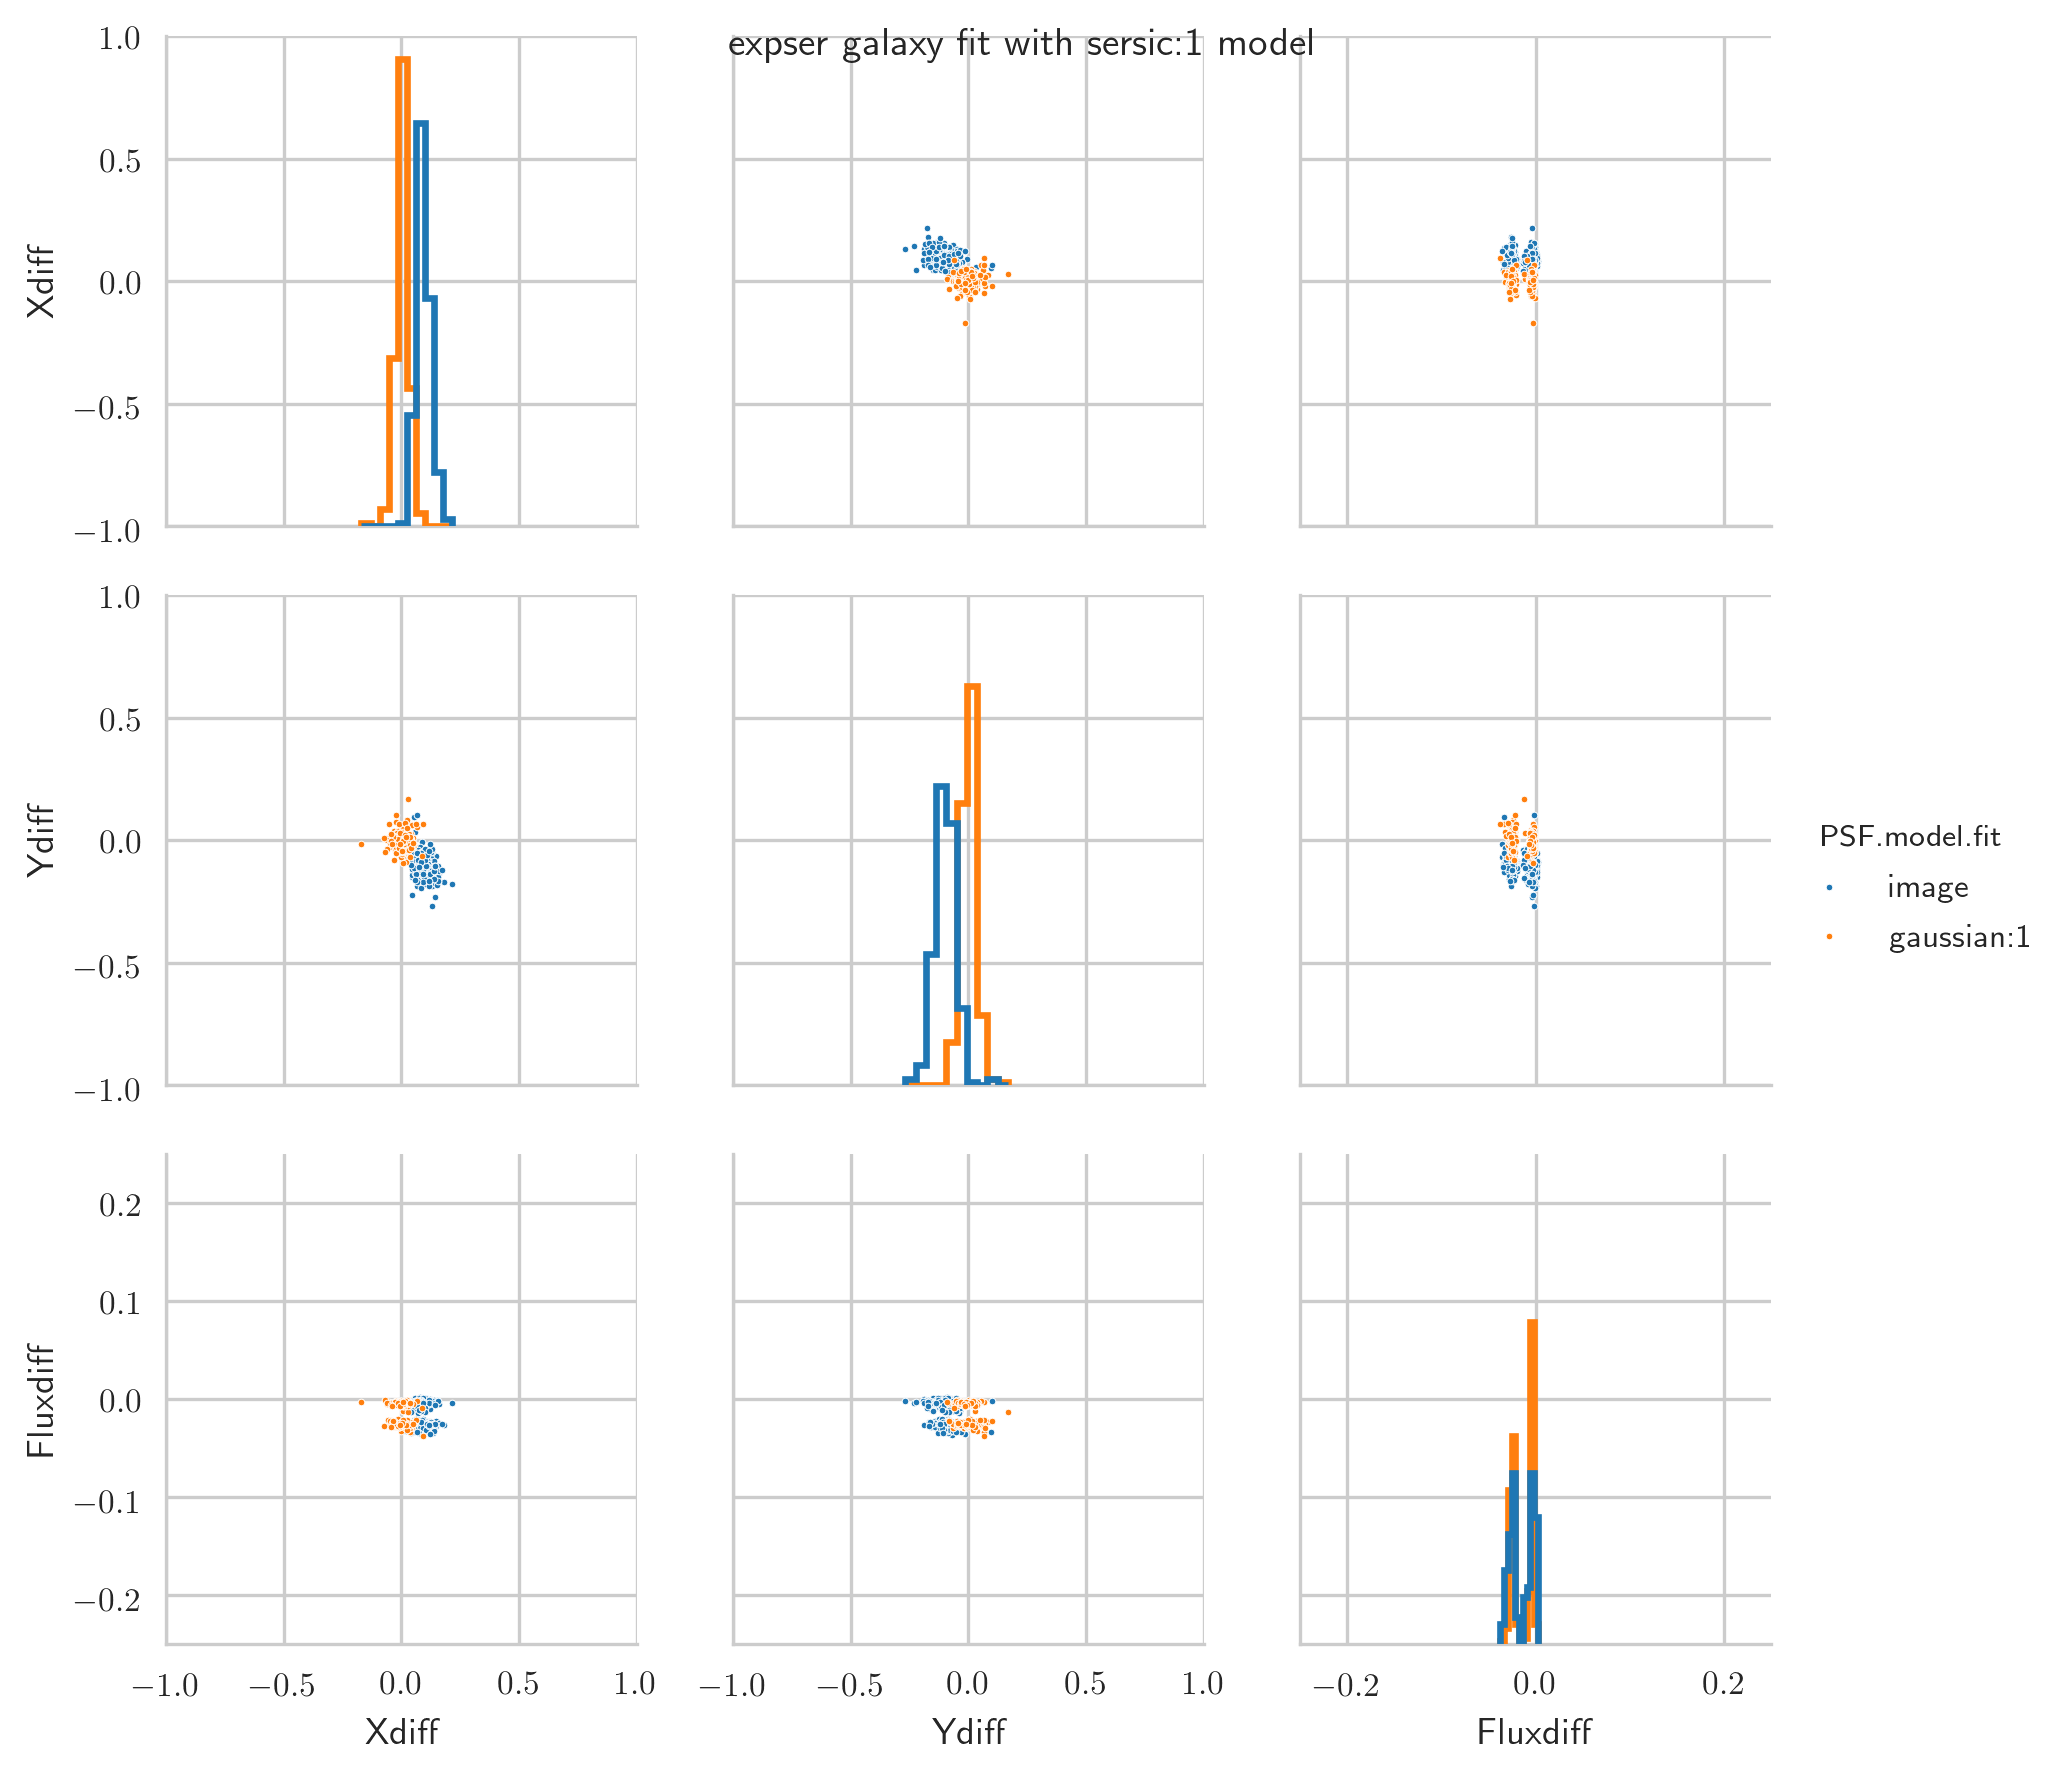

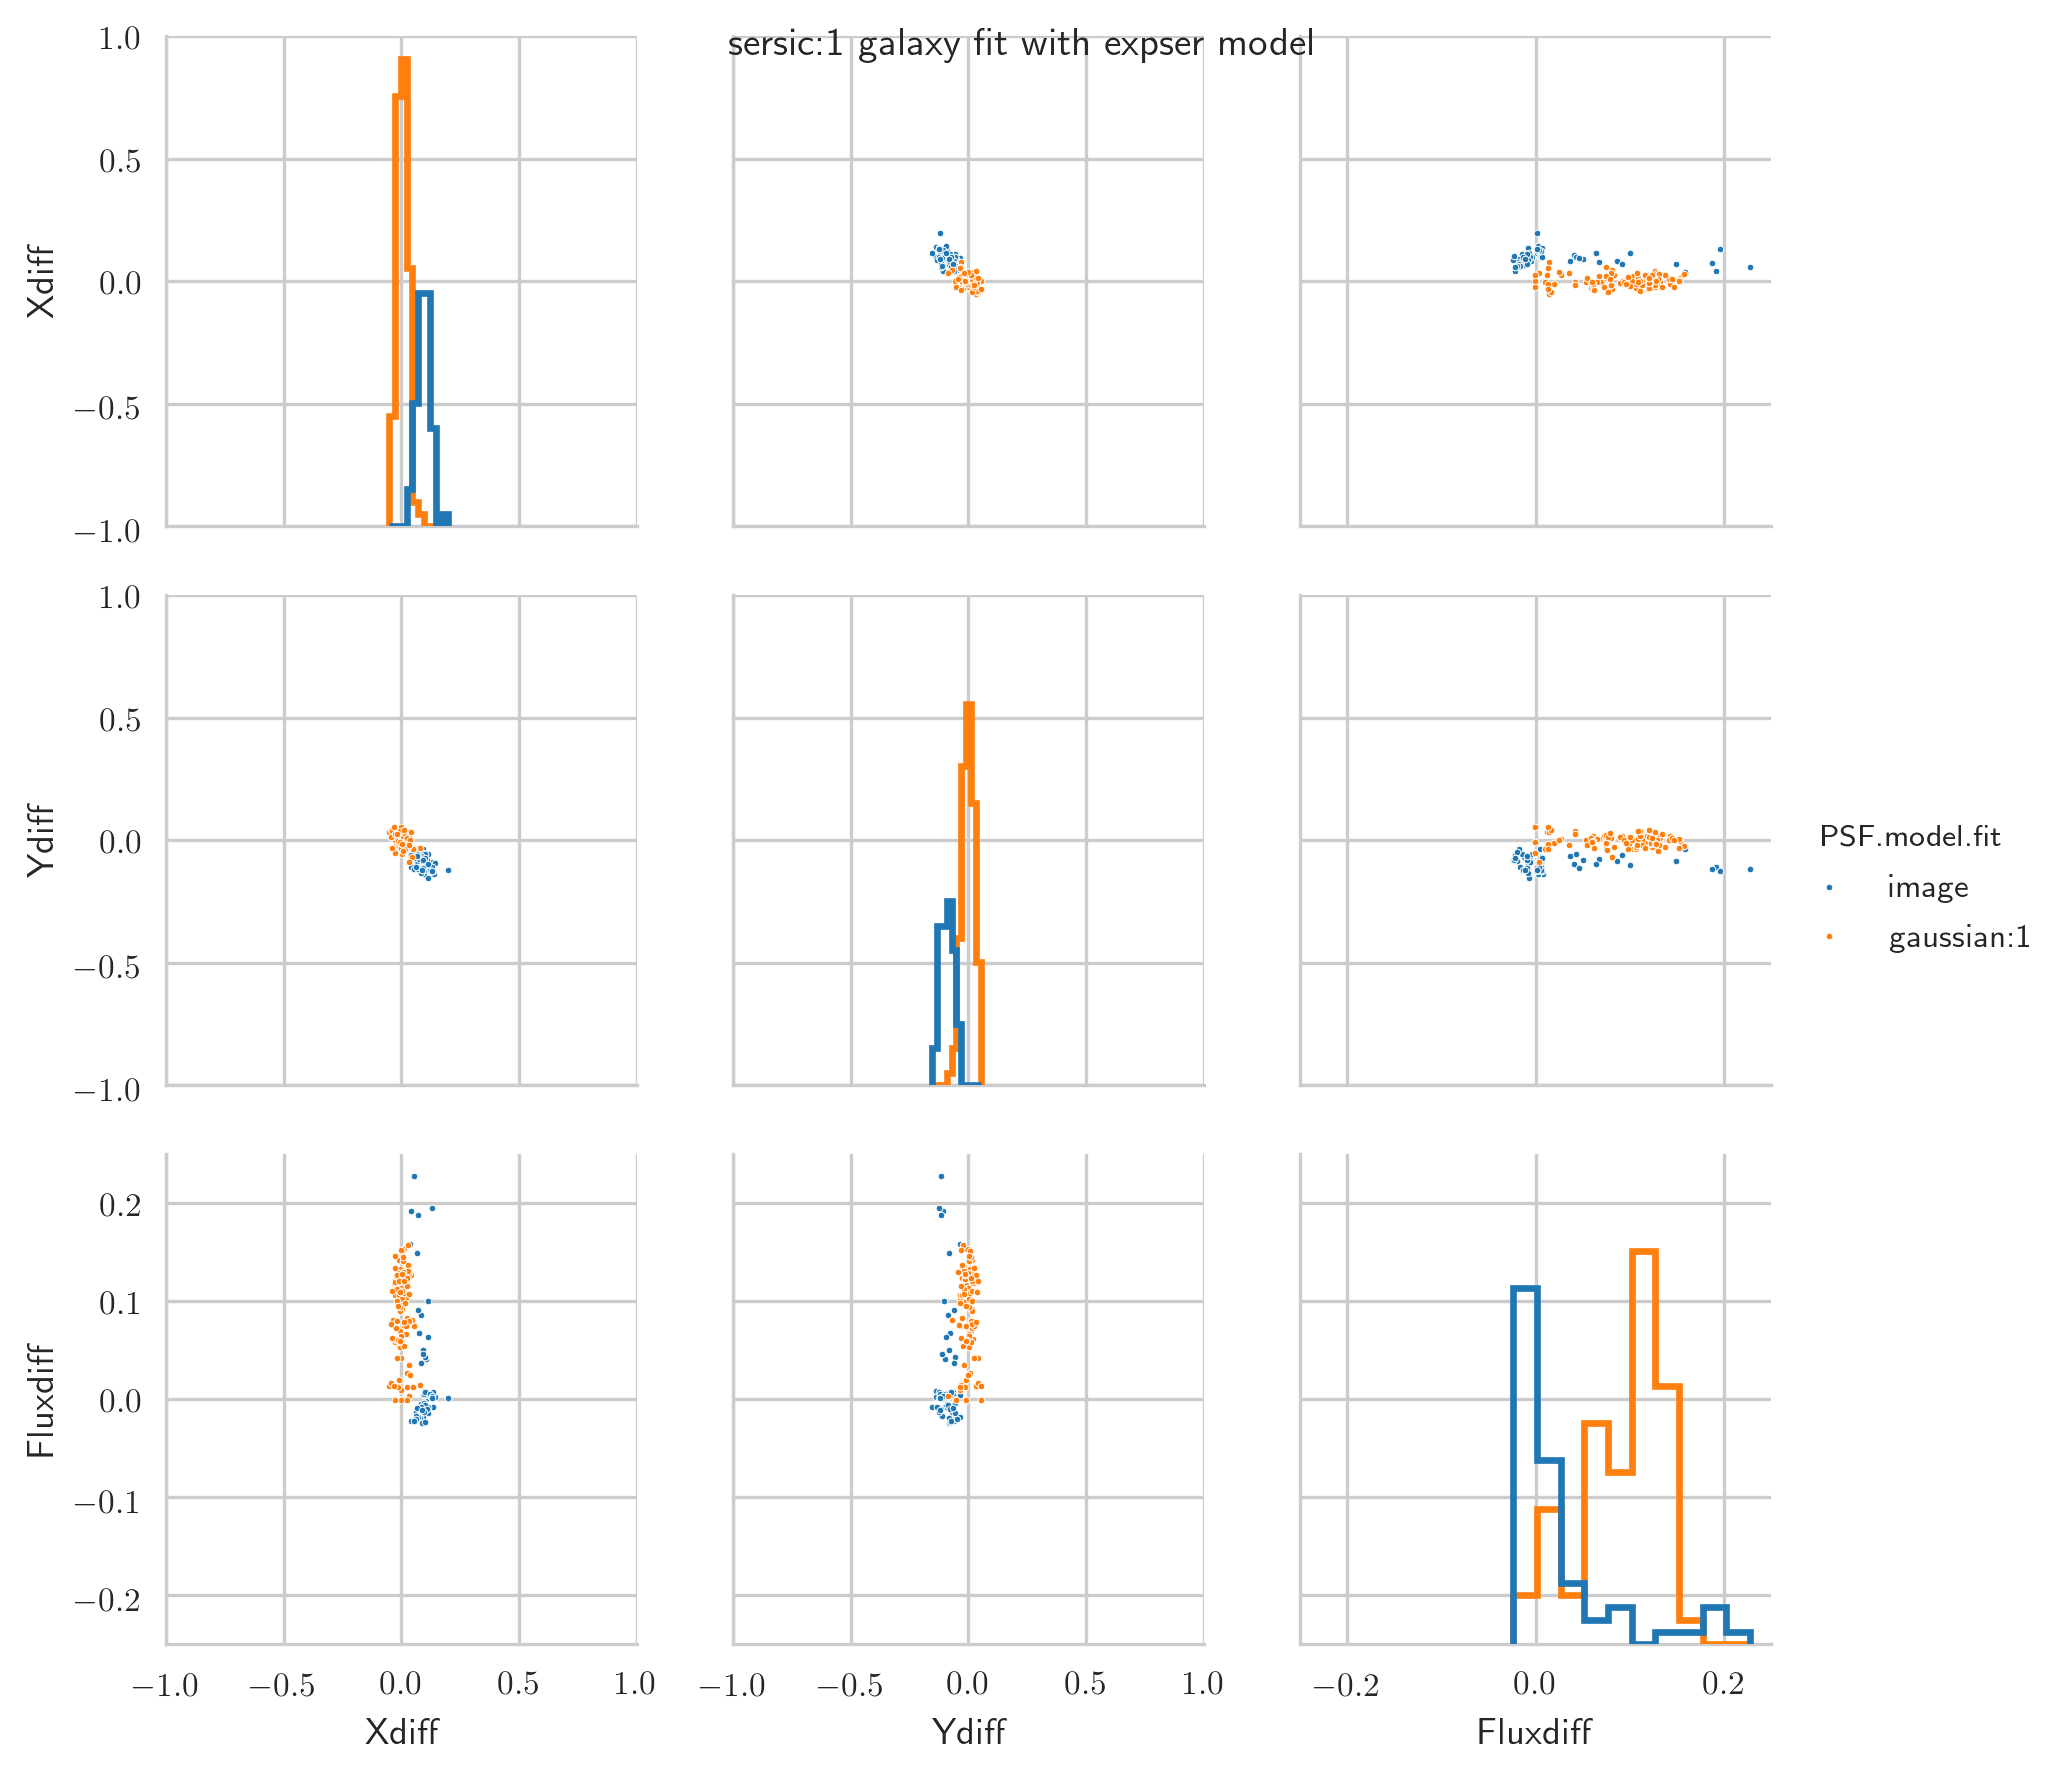

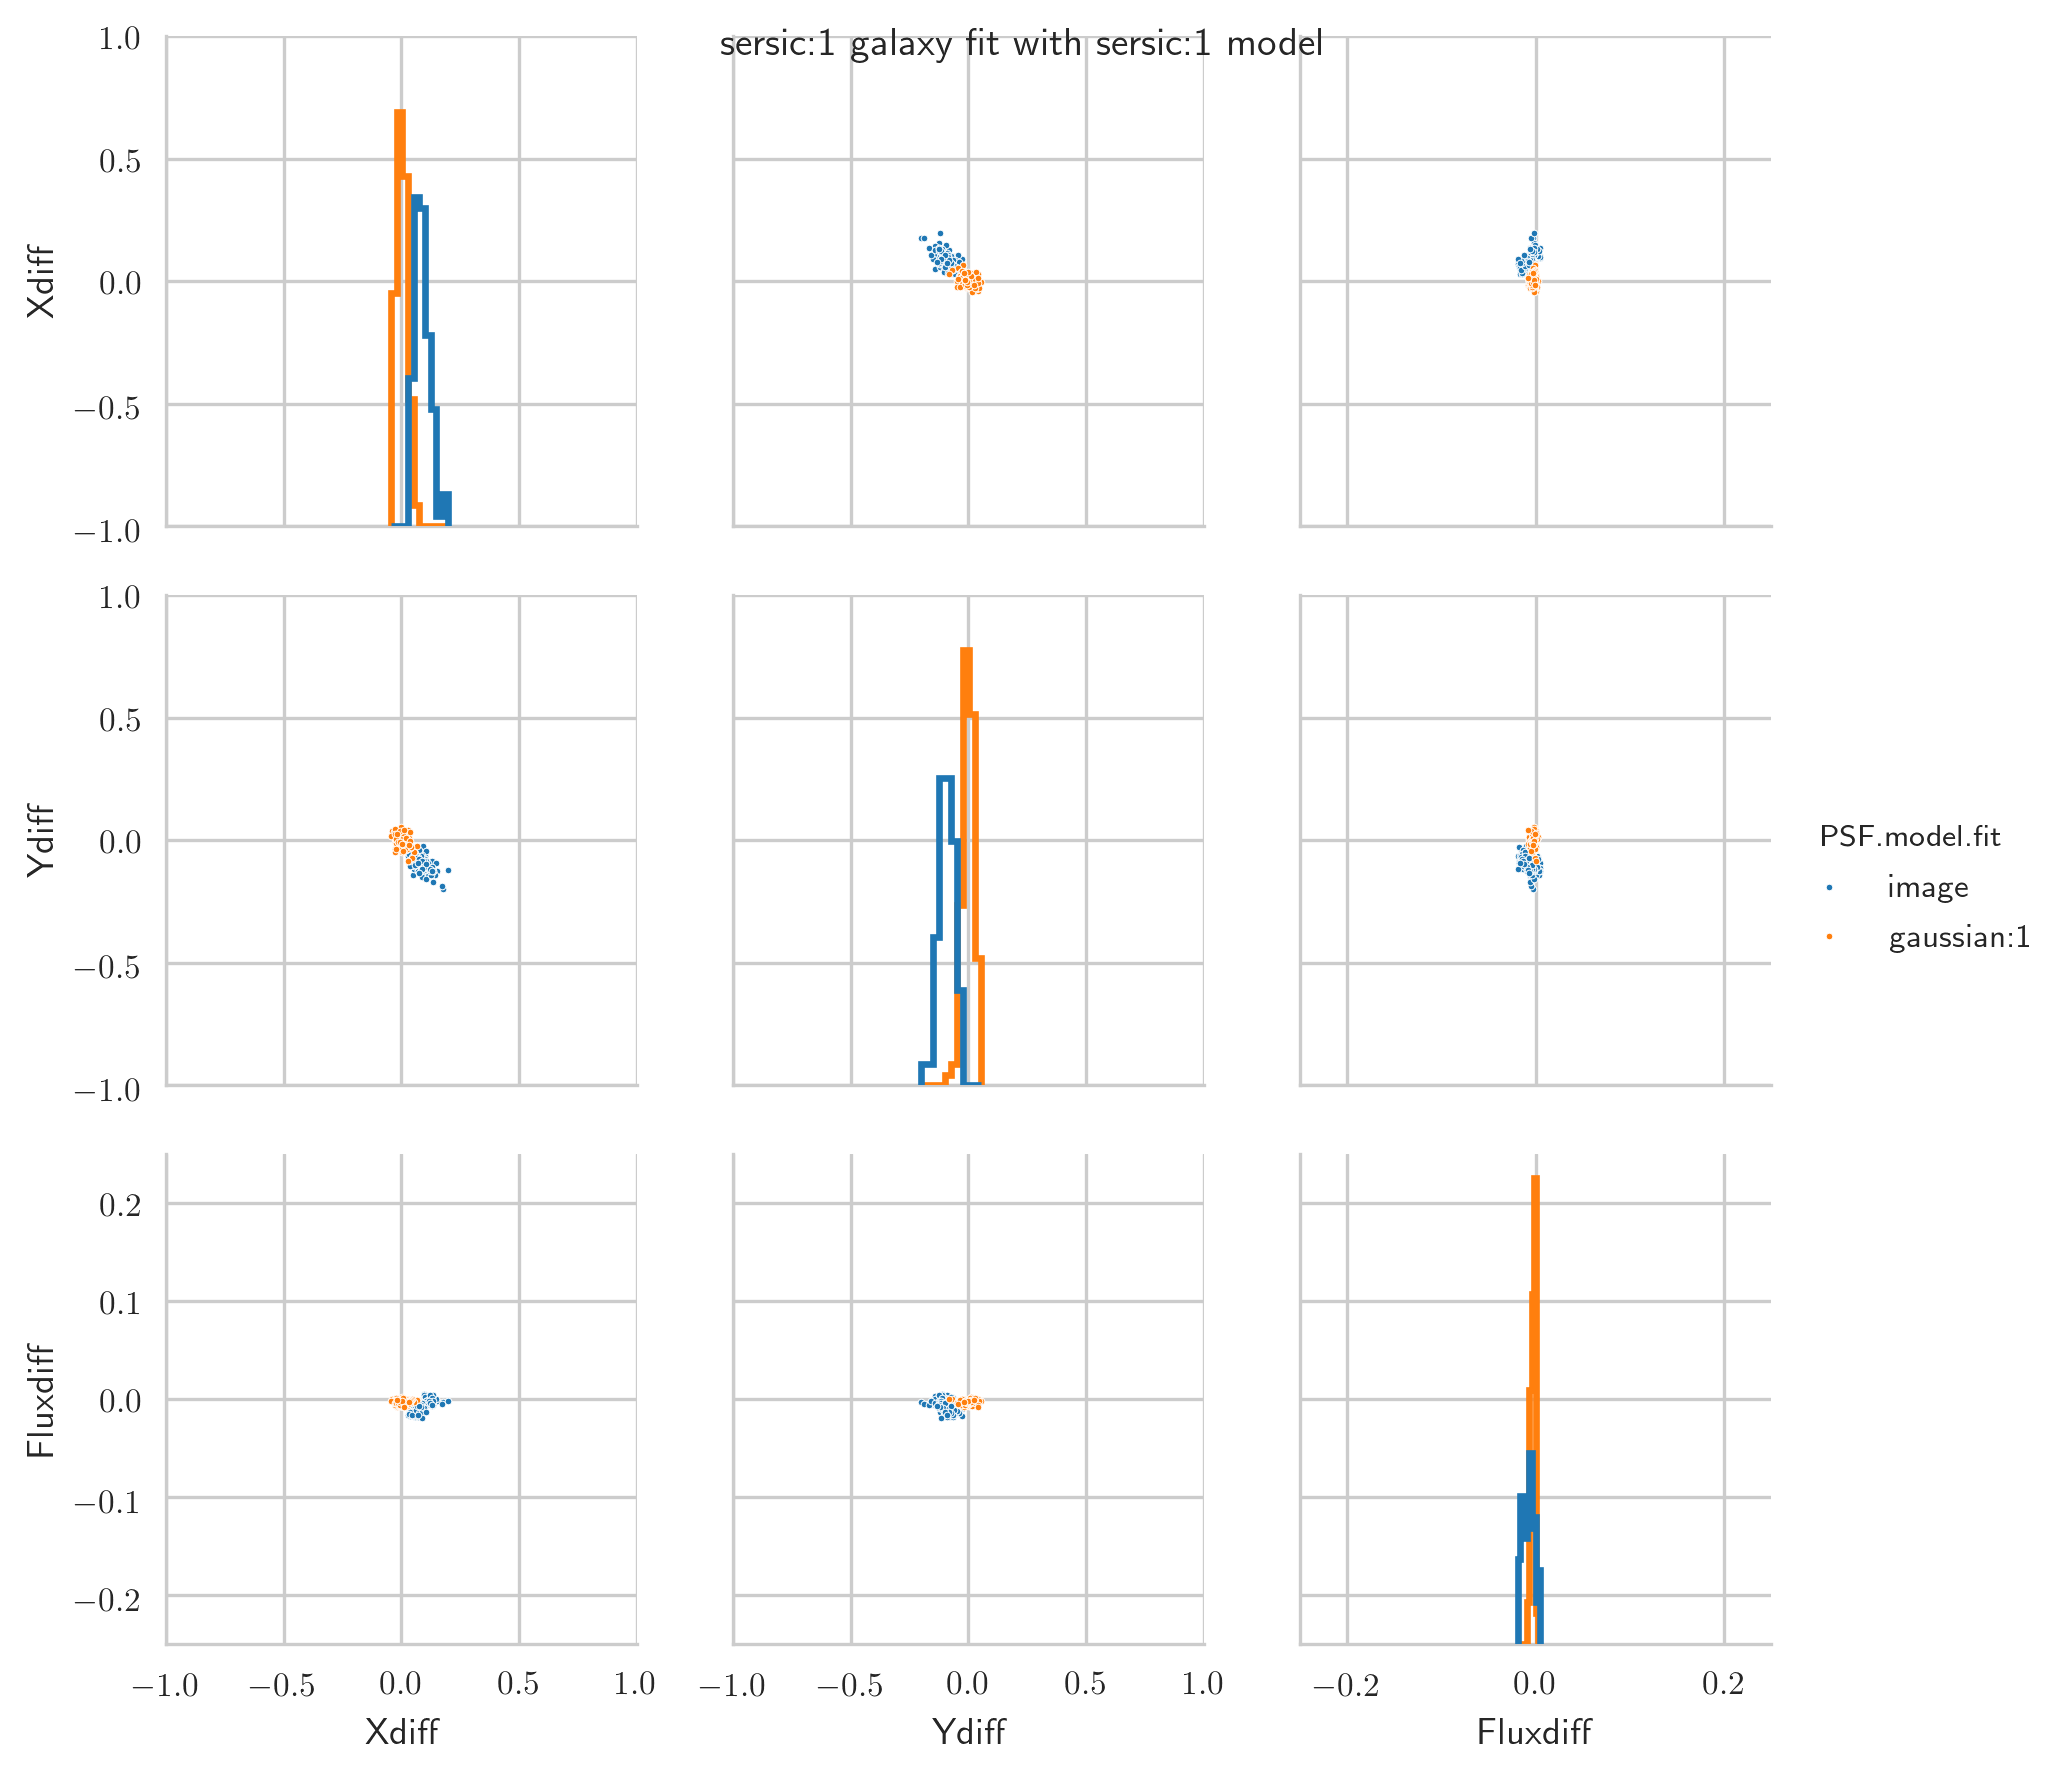

In [275]:
#%matplotlib inline
sns.set_style("whitegrid",{"axes.facecolor": "w"})
tableplot = table[["Xdiff","Ydiff","PSF.model.fit"]]
tableplot["Fluxdiff"] = (table["Flux.model"]-table["Flux.true"])/table["Flux.true"]
#figure, axes = plt.subplots(nrows=len(galaxymodels), ncols=len(galaxymodelsfit))
print(np.unique(table["Galaxy.model"]))
for psfmodel in psfmodels:
    filtpsf = (table["PSF.model"] == psfmodel)
    for galaxymodel in galaxymodels:
        filtgal = filtpsf & (table["Galaxy.model"] == galaxymodel)
        print(galaxymodel, np.sum(filtgal))
        for galaxymodelfit in galaxymodelsfit:
            filepath = path + "_".join(["modelfit",psfmodel,galaxymodel,galaxymodelfit]).replace(":","")
            filtall = filtgal & (table["Galaxy.model.fit"] == galaxymodelfit) & \
                      np.isfinite(table["Flux.model"])
            print(np.sum(filtall))
            psfmodelsfilt = np.unique(table[filtall]["PSF.model.fit"])
            plot = sns.pairplot(tableplot[filtall], plot_kws={"s": 4}, hue = "PSF.model.fit",
                                diag_kws=dict(histtype="step", linewidth=2))
            plot.fig.suptitle("{} galaxy fit with {} model".format(galaxymodel, galaxymodelfit))
            limits = [
                [-1., 1.],
                [-1., 1.],
                [-0.25, 0.25],
            ]
            for i, subaxes in enumerate(plot.axes):
                subaxes[i].set_xlim(limits[i])
                subaxes[i].set_ylim(limits[i])
            plot.savefig(fname=filepath + ".eps")
            plot.savefig(fname=filepath + ".png")

In [186]:
values = tableplot[filt].values
print(list(tableplot))
c = cc.ChainConsumer().add_chain(values, parameters=list(tableplot))
mpl.rcParams['figure.dpi'] = 100
c.plotter.plot(display=True)

['Xdiff', 'Ydiff', 'Fluxdiff']


/usr/lib64/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/lib64/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


RuntimeError: libpng signaled error

<Figure size 450x450 with 9 Axes>

RuntimeError: libpng signaled error

<Figure size 450x450 with 9 Axes>